In [47]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import mlflow

from modechoice.data import ensure_long_format, stratified_split_by_case
from modechoice.features import add_relative_features_long
from modechoice.tensors import build_choice_tensors_hetero
from modechoice.pipeline import ModeChoicePipeline
from modechoice.io import save_bundle
from modechoice.config import MODES

import json
import mlflow
import shutil

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [17]:
ROOT = Path.cwd()
if (ROOT / "pyproject.toml").exists() is False:
    # if cwd is notebooks/, step up
    ROOT = ROOT.parent

NOTEBOOK_PATH = ROOT / "notebooks" / "01_eda_and_training.ipynb"

DATA_PATH = ROOT / "dataset" / "ModeCanada.csv"
df_raw = pd.read_csv(DATA_PATH)
df_raw.head()

,Unnamed: 0,case,alt,choice,dist,cost,ivt,ovt,freq,income,urban,noalt
0,1,1,train,0,83,28.25,50,66,4,45,0,2
1,2,1,car,1,83,15.77,61,0,0,45,0,2
2,3,2,train,0,83,28.25,50,66,4,25,0,2
3,4,2,car,1,83,15.77,61,0,0,25,0,2
4,5,3,train,0,83,28.25,50,66,4,70,0,2


In [18]:
df_raw = df_raw.drop("Unnamed: 0", axis=1)

In [19]:
required = ["case", "alt", "choice", "cost", "ivt", "ovt", "freq", "income", "urban"]
missing = [col for col in required if col not in df_raw.columns]
assert not missing, f"Missing columns: {missing}"

In [20]:
df_raw["case"] = df_raw["case"].astype(int)
df_raw["choice"] = df_raw["choice"].astype(int)

In [ ]:
# each case should have exactly 1 chosen alternative
choice_sum = df_raw.groupby("case")["choice"].sum()
bad_cases = choice_sum[choice_sum != 1]
print("Cases with choice_sum != 1:", len(bad_cases))
display(bad_cases.head(10))

Cases with choice_sum != 1: 0


Series([], Name: choice, dtype: int64)

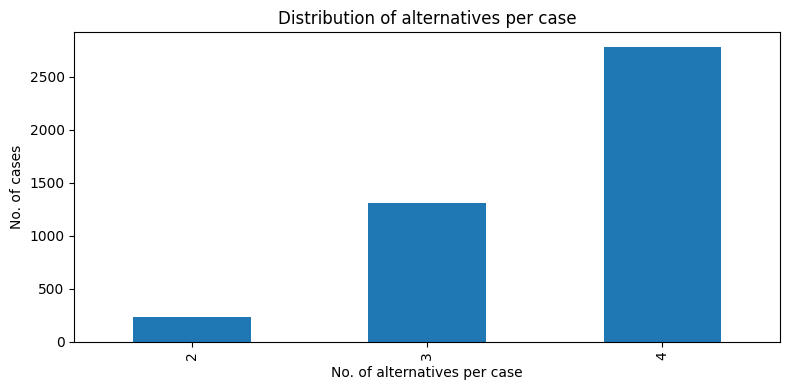

Alternatives per case distribution:
alt
2     231
3    1314
4    2779
Name: count, dtype: int64


In [ ]:
# show alternatives per case
dist = df_raw.groupby("case")["alt"].nunique().value_counts().sort_index()
ax = dist.plot(kind="bar", figsize=(8, 4))
ax.set_xlabel("No. of alternatives per case")
ax.set_ylabel("No. of cases")
ax.set_title("Distribution of alternatives per case")
plt.tight_layout()
plt.show()
print("Alternatives per case distribution:")
print(dist)

In [23]:
df_long = ensure_long_format(df_raw)
df_long = add_relative_features_long(df_long)

In [24]:
df_long.columns

Index(['case', 'alt', 'choice', 'dist', 'cost', 'ivt', 'ovt', 'freq', 'income',
       'urban', 'noalt', 'alt_id', 'cost_log', 'wait_time', 'gen_time',
       'min_cost_case', 'min_gen_time_case', 'rel_cost', 'rel_gen_time',
       'income_x_rel_cost', 'urban_x_ovt'],
      dtype='object')

In [ ]:
# item_feat_names = ["cost","ivt","ovt","freq","cost_log","wait_time","gen_time","rel_cost","rel_gen_time","income_x_rel_cost","urban_x_ovt"]
item_feat_names = ["cost", "ivt", "ovt", "freq", "urban_x_ovt", "gen_time"] # from optimization in another (scrapped) notebook
train_cases, val_cases, test_cases = stratified_split_by_case(df_long)

In [26]:
df_train = df_long[df_long["case"].isin(train_cases)]
df_val   = df_long[df_long["case"].isin(val_cases)]
df_test  = df_long[df_long["case"].isin(test_cases)]

In [27]:
train_t, scaler = build_choice_tensors_hetero(df_train, item_feat_names=item_feat_names, fit_scaler=True)
val_t, _        = build_choice_tensors_hetero(df_val, item_feat_names=item_feat_names, scaler=scaler)
test_t, _       = build_choice_tensors_hetero(df_test, item_feat_names=item_feat_names, scaler=scaler)


In [28]:
pipe = ModeChoicePipeline.fit(
    train_t=train_t,
    val_t=val_t,
    scaler=scaler,
    meta={"feat_names": train_t["feat_names"]},
    lr=0.05,
    max_epochs=800,
    patience=25,
    seed=0,
)

splits = {"TRAIN": train_t, "VAL": val_t, "TEST": test_t}

summary = pipe.evaluate_summary_all({"TRAIN": train_t, "VAL": val_t, "TEST": test_t}, detailed_on="TEST")
display(summary.round(4))

epoch   0 | train NLL=1.2302 | val NLL=1.0302
epoch 100 | train NLL=0.6269 | val NLL=0.6350
epoch 200 | train NLL=0.6226 | val NLL=0.6310
epoch 300 | train NLL=0.6208 | val NLL=0.6300
epoch 400 | train NLL=0.6199 | val NLL=0.6297
epoch 500 | train NLL=0.6194 | val NLL=0.6296
early stop @ epoch 578, best val NLL=0.6295

TEST
per-case NLL: 0.5967
accuracy:     0.7673
pred share:   {'train': 0.14096038043498993, 'car': 0.5020113587379456, 'bus': 0.003794480813667178, 'air': 0.35323381423950195}
actual share: {'train': 0.1448382126348228, 'car': 0.5115562403697997, 'bus': 0.0030816640986132513, 'air': 0.3405238828967643}

TEST — Confusion matrix


,pred_train,pred_car,pred_bus,pred_air
true_train,9,60,0,25
true_car,5,294,0,33
true_bus,0,2,0,0
true_air,3,23,0,195



Classification report
              precision    recall  f1-score   support

       train     0.5294    0.0957    0.1622        94
         car     0.7757    0.8855    0.8270       332
         bus     0.0000    0.0000    0.0000         2
         air     0.7708    0.8824    0.8228       221

    accuracy                         0.7673       649
   macro avg     0.5190    0.4659    0.4530       649
weighted avg     0.7360    0.7673    0.7267       649


ROC AUC macro: 0.851
ROC AUC weighted: 0.8908

PR AUC macro: 0.5439
PR AUC per class: {'train': 0.4234, 'car': 0.8784, 'bus': 0.0106, 'air': 0.8633}
supports: {'train': 94, 'car': 332, 'bus': 2, 'air': 221}


,split,nll,accuracy,pred_share_train,actual_share_train,pred_share_car,actual_share_car,pred_share_bus,actual_share_bus,pred_share_air,actual_share_air
0,TRAIN,0.6193,0.7601,0.1437,0.1441,0.5124,0.5119,0.0039,0.0036,0.3400,0.3404
1,VAL,0.6295,0.7612,0.1509,0.1433,0.4935,0.5116,0.0047,0.0046,0.3509,0.3405
2,TEST,0.5967,0.7673,0.1410,0.1448,0.5020,0.5116,0.0038,0.0031,0.3532,0.3405


In [29]:
asc_df, beta_df, lam_df = pipe.coef_tables()
display(asc_df.round(4)); display(beta_df.round(4)); display(lam_df.round(4))

,mode,ASC
3,air,1.3355
0,train,0.9830
1,car,-0.1278
2,bus,-1.6875


,feature,beta
0,cost,-2.2690
2,ovt,-1.4292
1,ivt,-1.1278
10,income_bus,-1.0365
12,income_air,0.9264
3,freq,0.8940
8,income_car,0.3490
4,urban_x_ovt,0.2038
7,urban_train,0.1537
5,gen_time,0.1065


,nest,lambda
0,air,0.6149
1,land,0.9137


In [ ]:
import importlib
import modechoice.io
importlib.reload(modechoice.io)

from modechoice.io import save_bundle

MLRUNS_DIR = (ROOT / "mlruns").resolve()
ART_DIR    = (ROOT / "artifacts").resolve()

MLRUNS_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(MLRUNS_DIR.as_uri())
mlflow.set_experiment("modechoice_nestedlogit")

splits = {"TRAIN": train_t, "VAL": val_t, "TEST": test_t}
summary_df = pipe.evaluate_summary_all(splits, detailed_on="TEST", show_detailed=False)

bundle_dir = ART_DIR / "modechoice_bundle"

if bundle_dir.exists() and bundle_dir.is_file():
    bundle_dir.unlink()

# for a clean bundle each run, delete the old folder and recreate
if bundle_dir.exists() and bundle_dir.is_dir():
    shutil.rmtree(bundle_dir)

bundle_dir.mkdir(parents=True, exist_ok=True)

save_bundle(bundle_dir, pipe)

print("bundle_dir:", bundle_dir)
print("is_dir:", bundle_dir.is_dir())
print("contents:", [p.name for p in bundle_dir.iterdir()])

save_bundle(bundle_dir, pipe)

summary_csv = ART_DIR / "eval_summary.csv"
summary_df.to_csv(summary_csv, index=False)

with mlflow.start_run(run_name="nestedlogit_hetero"):
    # params
    mlflow.log_params({
        "model": "nested_logit_hetero",
        "modes": ",".join(MODES),
        "n_train": int(len(train_t["y"])),
        "n_val": int(len(val_t["y"])),
        "n_test": int(len(test_t["y"])),
        "feat_names": ",".join(pipe.scaler.feat_names),
    })

    # metrics (TEST)
    test_row = summary_df.loc[summary_df["split"] == "TEST"].iloc[0].to_dict()
    mlflow.log_metrics({
        "test_nll": float(test_row["nll"]),
        "test_accuracy": float(test_row["accuracy"]),
    })

    # artifacts
    mlflow.log_artifacts(str(bundle_dir), artifact_path="model")
    mlflow.log_artifact(str(summary_csv), artifact_path="eval")
    mlflow.log_text(json.dumps(pipe.meta, indent=2), artifact_file="meta.json")

    if NOTEBOOK_PATH.exists():
        mlflow.log_artifact(str(NOTEBOOK_PATH), artifact_path="notebooks")

print("Logged run to MLflow.")
print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment:", mlflow.get_experiment_by_name("modechoice_nestedlogit").name)

bundle_dir: C:\Users\aimaul\workspace\mode-choice\artifacts\modechoice_bundle
is_dir: True
contents: ['meta.json', 'model.pt', 'scaler.json']
Logged run to MLflow.
Tracking URI: file:///C:/Users/aimaul/workspace/mode-choice/mlruns
Experiment: modechoice_nestedlogit
